# Ressources

* https://www.tensorflow.org/lite/tutorials/model_maker_object_detection
* https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector
* https://coral.ai/docs/edgetpu/retrain-detection/
* https://github.com/google-coral/tflite/tree/master/python/examples/detection
* https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi

In [3]:
%%shell

nvidia-smi

Wed Aug 25 14:26:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%shell 

# see https://discuss.tensorflow.org/t/invalidargumenterror-required-broadcastable-shapes-op-mul/3824/4
# pip install tensorflow==2.5.0
# pip install tflite-model-maker
pip install tflite-model-maker-nightly

     |████████████████████████████████| 620 kB 3.8 MB/s 
     |████████████████████████████████| 120 kB 56.0 MB/s 
     |████████████████████████████████| 1.1 MB 21.4 MB/s 
     |████████████████████████████████| 211 kB 51.0 MB/s 
     |████████████████████████████████| 6.3 MB 38.0 MB/s 
     |████████████████████████████████| 1.1 MB 37.4 MB/s 
     |████████████████████████████████| 87 kB 6.2 MB/s 
     |████████████████████████████████| 636 kB 33.1 MB/s 
     |████████████████████████████████| 3.4 MB 28.8 MB/s 
     |████████████████████████████████| 840 kB 32.1 MB/s 
     |████████████████████████████████| 1.2 MB 35.5 MB/s 
     |████████████████████████████████| 25.3 MB 78 kB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
     |████████████████████████████████| 99 kB 9.3 MB/s 
     |████████████████████████████████| 37.1 MB 39 kB/s 
     |████████████████████████████████| 352 kB 27.8 MB/s 
     |████████████████████████████████| 200 kB 39.8 MB/s 
  Created wheel for f

# Installation du projet `bfc` et accès aux données

Les login et mot de passe sont nécessaires pour accéder à des repos privés à partir de Google/Colab. Cela ne serait pas le cas en accès public.

In [4]:
import os
from getpass import getpass

In [6]:
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password

GitHub user··········
GitHub password··········


In [7]:
%%shell

git clone https://$GITHUB_AUTH@github.com/tibocour/IA.git

Cloning into 'IA'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 2), reused 18 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [8]:
%%shell

rm -rf Annotations images
unzip -q IA/data/megots150images.zip

# Préparation des données

Le format `Pascal VOC` de `Label Studio` est encodé en `utf-8` ce qui n'est pas supporté par `tensorflow-lite`. D'autre part, le label `filename` des fichiers `xml` ne contient pas l'extension `.jpg`. 

In [9]:
import os

In [10]:
os.makedirs("annotations", exist_ok=True)

In [11]:
for filename in os.listdir("Annotations"):
    with open(os.path.join("Annotations", filename), 'r') as file :
        filedata = file.read()

    filedata = filedata.replace(' encoding="utf-8"', "")
    filedata = filedata.replace("</filename>", ".jpg</filename>")

    with open(os.path.join("annotations", filename), 'w') as file:
        file.write(filedata)

On effectue une répartition aléatoire des données 80% pour l'entrainement et le reste pour la validation.

> C'est vraiment grossier. Dans le cas d'une détection à plusieurs classes, il convient d'avoir une stratégie plus adaptée pour ne pas sur / sous représenter des catégories.

In [12]:
filenames = [os.path.splitext(filename)[0] for filename in os.listdir("Annotations")]

In [13]:
import random

In [14]:
random.shuffle(filenames)

In [15]:
train_size = int(len(filenames) * 0.8)

In [16]:
train_filenames = filenames[:train_size]
valid_filenames = filenames[train_size:]

# Apprentissage par transfer learning

In [17]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [18]:
from tflite_model_maker import object_detector

In [19]:
train_data = object_detector.DataLoader.from_pascal_voc(
    images_dir="images",
    annotations_dir="annotations",
    annotation_filenames=train_filenames,
    label_map=["megot"]
)

INFO:tensorflow:Cache will be stored in /tmp/tmp2ij389pm with prefix filename 1c97ed988c3f4ceb234698c23d258e2a. Cache_prefix is /tmp/tmp2ij389pm/1c97ed988c3f4ceb234698c23d258e2a
INFO:tensorflow:On image 0
INFO:tensorflow:On image 100


In [20]:
valid_data = object_detector.DataLoader.from_pascal_voc(
    images_dir="images",
    annotations_dir="annotations",
    annotation_filenames=valid_filenames,
    label_map=["megot"]
)

INFO:tensorflow:Cache will be stored in /tmp/tmp_8s3nzjo with prefix filename 91236c2603930c40de5ab93bf11d91de. Cache_prefix is /tmp/tmp_8s3nzjo/91236c2603930c40de5ab93bf11d91de
INFO:tensorflow:On image 0


In [21]:
len(train_data), len(valid_data)

(117, 30)

Architecture de detection : [EfficientDet](https://arxiv.org/pdf/1911.09070.pdf)
voir également [ici](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html) pour les détails.

In [22]:
spec = object_detector.EfficientDetLite0Spec()

In [ ]:
model = object_detector.create(train_data=train_data,
                               model_spec=spec,
                               validation_data=valid_data,
                               epochs=50,
                               batch_size=10,
                               train_whole_model=True)

INFO:tensorflow:Retraining the models...
Epoch 1/50
11/11 [==============================] - 74s 1s/step - det_loss: 1.7422 - cls_loss: 1.1305 - box_loss: 0.0122 - reg_l2_loss: 0.0630 - loss: 1.8051 - learning_rate: 0.0102 - gradient_norm: 1.7865 - val_det_loss: 1.6254 - val_cls_loss: 1.0625 - val_box_loss: 0.0113 - val_reg_l2_loss: 0.0630 - val_loss: 1.6884
Epoch 2/50
11/11 [==============================] - 7s 600ms/step - det_loss: 1.4795 - cls_loss: 0.9450 - box_loss: 0.0107 - reg_l2_loss: 0.0630 - loss: 1.5424 - learning_rate: 0.0125 - gradient_norm: 2.0787 - val_det_loss: 1.0527 - val_cls_loss: 0.5795 - val_box_loss: 0.0095 - val_reg_l2_loss: 0.0630 - val_loss: 1.1156
Epoch 3/50
11/11 [==============================] - 6s 600ms/step - det_loss: 0.9724 - cls_loss: 0.5229 - box_loss: 0.0090 - reg_l2_loss: 0.0630 - loss: 1.0354 - learning_rate: 0.0124 - gradient_norm: 3.4097 - val_det_loss: 1.2637 - val_cls_loss: 0.8455 - val_box_loss: 0.0084 - val_reg_l2_loss: 0.0630 - val_loss: 1.

In [ ]:
model.evaluate(train_data)

2/2 [==============================] - 21s 9s/step

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(11700, 7)
0/11700
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.54s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.852
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.869
 Average Recall     (AR) @[ IoU=0.50:0.95

{'AP': 0.85182446,
 'AP50': 1.0,
 'AP75': 1.0,
 'AP_/megot': 0.85182446,
 'APl': 0.851936,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.8965812,
 'ARm': -1.0,
 'ARmax1': 0.86923075,
 'ARmax10': 0.8940171,
 'ARmax100': 0.8965812,
 'ARs': -1.0}

In [ ]:
model.evaluate(valid_data)

1/1 [==============================] - 8s 8s/step

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(3000, 7)
0/3000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

{'AP': 0.7656801,
 'AP50': 1.0,
 'AP75': 0.92973596,
 'AP_/megot': 0.7656801,
 'APl': 0.76598155,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.83666664,
 'ARm': -1.0,
 'ARmax1': 0.78333336,
 'ARmax10': 0.83666664,
 'ARmax100': 0.83666664,
 'ARs': -1.0}

In [ ]:
from tflite_model_maker.config import ExportFormat

In [ ]:
model.export(export_dir='.',
             tflite_filename='efficientdet-lite-bfc.tflite',
             label_filename='bfc-labels.txt',
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

INFO:tensorflow:Assets written to: /tmp/tmpgxz7htyz/assets


INFO:tensorflow:Assets written to: /tmp/tmpgxz7htyz/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp0dsmxxn5/labelmap.txt.


INFO:tensorflow:Saving labels in /tmp/tmp0dsmxxn5/labelmap.txt.


INFO:tensorflow:Finished populating metadata and associated file to the model:


INFO:tensorflow:Finished populating metadata and associated file to the model:


INFO:tensorflow:./efficientdet-lite-bfc.tflite


INFO:tensorflow:./efficientdet-lite-bfc.tflite


INFO:tensorflow:The associated file that has been been packed to the model is:


INFO:tensorflow:The associated file that has been been packed to the model is:


INFO:tensorflow:['labelmap.txt']


INFO:tensorflow:['labelmap.txt']


INFO:tensorflow:TensorFlow Lite model exported successfully: ./efficientdet-lite-bfc.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./efficientdet-lite-bfc.tflite


INFO:tensorflow:Saving labels in ./bfc-labels.txt.


INFO:tensorflow:Saving labels in ./bfc-labels.txt.


In [ ]:
model = 

In [ ]:
model.evaluate_tflite('efficientdet-lite-bfc.tflite', train_data)

117/117 [==============================] - 318s 3s/step

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2925, 7)
0/2925
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.831
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.863
 Average Recall     (AR) @[ IoU=0.50:0

{'AP': 0.8311202,
 'AP50': 1.0,
 'AP75': 1.0,
 'AP_/megot': 0.8311202,
 'APl': 0.8311202,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.8632479,
 'ARm': -1.0,
 'ARmax1': 0.8632479,
 'ARmax10': 0.8632479,
 'ARmax100': 0.8632479,
 'ARs': -1.0}

In [ ]:
model.evaluate_tflite('efficientdet-lite-bfc.tflite', valid_data)

30/30 [==============================] - 83s 3s/step

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(750, 7)
0/750
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 |

{'AP': 0.743105,
 'AP50': 1.0,
 'AP75': 0.91410893,
 'AP_/megot': 0.743105,
 'APl': 0.743105,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.78,
 'ARm': -1.0,
 'ARmax1': 0.78,
 'ARmax10': 0.78,
 'ARmax100': 0.78,
 'ARs': -1.0}

# Inférence

A partir d'ici, la librairie `tflite-model-maker` est inutile. On utilise nativement `tflite`.

Le code suivant est une alternative à l'outillage proposé pour le Coral TPU, voir [ici](https://github.com/google-coral/tflite/tree/master/python/examples/detection).

In [80]:
import numpy as np
import cv2

from PIL import Image

# Load the labels into a list
classes = ["megot"]

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 1)
  classes = get_output_tensor(interpreter, 3)
  scores = get_output_tensor(interpreter, 0)
  count = int(get_output_tensor(interpreter, 2))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

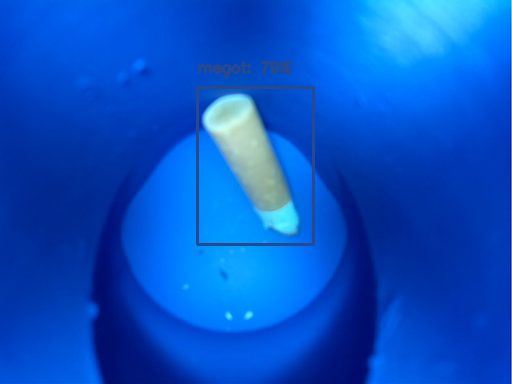

In [82]:
im = Image.open("images/1608644703.jpg")
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save("/tmp/image.png", 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="efficientdet-lite-bfc.tflite")
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    "/tmp/image.png",
    interpreter,
    threshold=0.5
)

# Show the detection result
Image.fromarray(detection_result_image)